# Testing Unsupervised + Supervised for Electricity Data

In [91]:
# Import necessary libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

import mysql.connector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, accuracy_score, precision_score, f1_score
from sklearn.utils import resample
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

## Datasets

In [92]:
# Configure database connection
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'db_esp32'
}

In [93]:
# Fetch data from the database with only power > 0 and order by created_at in descending order
def fetch_data():
    conn = mysql.connector.connect(**db_config)
    query = f"SELECT data_id, voltage, current, power, energy, power_factor, frequency FROM electricity_monitor WHERE power > 0 ORDER BY created_at DESC"
    df = pd.read_sql(query, conn)
    conn.close()
    return df

# Resample the data to 10% of the original dataset
def sampled_data():
    df_data = fetch_data()
    df_sampled = resample(df_data, replace=False, n_samples=int(len(df_data) * 0.2), random_state=42)

    return df_sampled

In [94]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [95]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

## Pre-processing

### Load Datasets

In [96]:
df = fetch_data()
df_sampled = sampled_data()

print(df.head())

C:\Users\Sabian\AppData\Local\Temp\ipykernel_20028\1266917687.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   data_id  voltage  current  power  energy  power_factor  frequency
0   117929    209.6      0.0    0.4   0.792           1.0       49.9
1   117926    210.0      0.0    0.4   0.792           1.0       49.9
2   117923    209.8      0.0    0.4   0.792           1.0       50.0
3   117922    209.4      0.0    0.4   0.792           1.0       49.9
4   117914    209.7      0.0    0.4   0.792           1.0       50.0


#### Convert datetime into numeric

In [97]:
# df['created_at'] = df['created_at'].astype('int64') // 10**9



#### Handling missing values

In [98]:
# print(df.isnull().sum())
# df.fillna(df.median(), inplace=True)

#### Calculate new features

In [99]:
# Calculate features
def calculate_features(df):
    df['mean_consumption'] = df['energy'].mean()
    df['std_deviation'] = df['energy'].std()
    df['peak_consumption'] = df['energy'].max()
    return df[['mean_consumption', 'std_deviation', 'peak_consumption', 'created_at']].iloc[-1]


In [100]:
# new_features = calculate_features(df)

## Unsupervised


In [101]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

#### IF

In [102]:
clf_if = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['if_labels'] = clf_if.fit_predict(df)

#### OCSVM

In [103]:
# ocsvm = OneClassSVM(nu=0.1, gamma='auto')
# df['ocsvm_labels'] = ocsvm.fit_predict(df)  


#### DBSCAN

In [104]:
# def label_data_with_dbscan(df, eps=0.2, min_samples=25):
#     features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
    
#     clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[features])
#     df['dbscan_labels'] = clustering.labels_
#     return df

# df_sample = df.sample(n=2000, random_state=42)

# label_data_with_dbscan(df_sample)
# print("DBSCAN Labels Distribution:")

# # Visualize DBSCAN results
# sns.scatterplot(x='voltage', y='current', hue='dbscan_labels', data=df_sample)
# plt.title('DBSCAN Clustering')
# plt.show()

#### Cluster levels `normal` and `anomaly`

In [105]:
df['if_labels'] = np.where(df['if_labels'] == 1, 'normal', 'anomaly')
# df['ocsvm_labels'] = np.where(df['ocsvm_labels'] == 1, 'normal', 'anomaly')
# # For DBSCAN, label -1 is considered an anomaly
# df['dbscan_labels'] = np.where(df['dbscan_labels'] == -1, 'anomaly', 'normal')

In [106]:
print(df.head())

   data_id  voltage  current  power  energy  power_factor  frequency if_labels
0   117929    209.6      0.0    0.4   0.792           1.0       49.9    normal
1   117926    210.0      0.0    0.4   0.792           1.0       49.9    normal
2   117923    209.8      0.0    0.4   0.792           1.0       50.0    normal
3   117922    209.4      0.0    0.4   0.792           1.0       49.9    normal
4   117914    209.7      0.0    0.4   0.792           1.0       50.0    normal


In [107]:
filtered_df = df[df['power'] > 10]

print(filtered_df.head())

     data_id  voltage  current  power  energy  power_factor  frequency  \
225   117311    209.5    0.097   11.5   0.792          0.57       50.0   
226   117310    208.3    0.099   11.7   0.792          0.57       50.0   
227   117309    208.0    0.099   11.6   0.792          0.56       50.0   
228   117308    208.2    0.099   11.7   0.792          0.57       50.0   
229   117307    207.3    0.100   11.7   0.792          0.56       50.0   

    if_labels  
225    normal  
226    normal  
227    normal  
228    normal  
229    normal  


## Supervised

### RF to IF

voltage: 0.13902051655801423
current: 0.21932186091394132
power: 0.20376408513990657
energy: 0.2320793987828605
frequency: 0.09313952090656617
power_factor: 0.11267461769871129


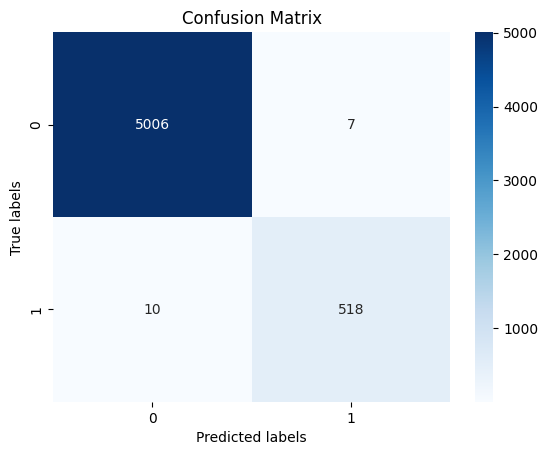

In [108]:
# 'anomaly' is 1 and 'normal' is 0
df['target'] = df['if_labels'].apply(lambda x: 1 if x == 'anomaly' else 0)

# Selecting features for the model (excluding IDs and labels)
X = df[['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']]
y = df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Getting feature importances
feature_importances = clf.feature_importances_

# Printing feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")
    
# Make predictions on the test set
y_pred = clf.predict(X_test)
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix (Optional)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### RF to DBSCAN

In [109]:
# # 'anomaly' is 1 and 'normal' is 0
# df['target'] = df['dbscan_labels'].apply(lambda x: 1 if x == 'anomaly' else 0)

# # Selecting features for the model (excluding IDs and labels)
# X = df[['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']]
# y = df['target']

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Training a Random Forest Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Getting feature importances
# feature_importances = clf.feature_importances_

# # Printing feature importances
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance}")
    
# # Make predictions on the test set
# y_pred = clf.predict(X_test)
# # Generate the confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# #
# print(df['dbscan_labels'].value_counts())
# print(df['dbscan_labels'])

# # Visualize the confusion matrix (Optional)
# sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()

### RF to OCSVM

In [110]:
# # 'anomaly' is 1 and 'normal' is 0
# df['target'] = df['ocsvm_labels'].apply(lambda x: 1 if x == 'anomaly' else 0)

# # Selecting features for the model (excluding IDs and labels)
# X = df[['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']]
# y = df['target']

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Training a Random Forest Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Getting feature importances
# feature_importances = clf.feature_importances_

# # Printing feature importances
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance}")

# # Make predictions on the test set
# y_pred = clf.predict(X_test)

# # Generate the confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Visualize the confusion matrix (Optional)
# sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix')
# plt.show()

### RF confusion Matrix

#### Result